In [1]:
import copy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial import cKDTree
import xarray as xr
import yaml

### Files paths

In [2]:
yaml_file = './config/pre_processing.yaml'
params = yaml.safe_load(open(yaml_file))

# The global mesh
INPUT_GRID = params['input_grid_nc']

# The SSH and seg masks info
INPUT_PATH_SSH_SEG_MASK = params['input_path_ssh_seg_masks']

# Output mesh details
OUTPUT_PATH_MESH = params['output_subset_pre_proc']

# The /raw destination folder for the pre-processed data
OUTPUT_SUBSET_PRE_PROCESSED = params['output_subset_pre_proc_raw']

In [3]:
%%html
<!--This cell just sets the following markdown block to align the table elements to the left-->
<style>
table {float:left}
</style>

### Boundaries of the 8 sub-regions

The 8 internal sub-regions will be associated to ID numbers from 1 to 8.

Considering the following table as the matricial representation of the region of interest, the IDs of these sub-regions will follow this order:

|     |     |     |     |
| --- | --- | --- | --- |
|  1  |  2  |  3  |  4  |
|  5  |  6  |  7  |  8  |


In [4]:
left = params['input_left']
right = params['input_right']
bottom = params['input_bottom']
top = params['input_top']

h_pad = (right-left)/4 
v_pad = (top-bottom)/2

coord = {'left': [], 'right': [], 'bottom': [], 'top': []}

# 1/8 subgraph
coord['left'].append(left)
coord['right'].append(left + h_pad)
coord['bottom'].append(bottom + v_pad)
coord['top'].append(top)

# 2/8 subgraph
coord['left'].append(left + h_pad)
coord['right'].append(left + 2*h_pad)
coord['bottom'].append(bottom + v_pad)
coord['top'].append(top)

# 3/8 subgraph
coord['left'].append(left + 2*h_pad)
coord['right'].append(left + 3*h_pad)
coord['bottom'].append(bottom + v_pad)
coord['top'].append(top)

# 4/8 subgraph
coord['left'].append(left + 3*h_pad)
coord['right'].append(right)
coord['bottom'].append(bottom + v_pad)
coord['top'].append(top)

# 5/8 subgraph
coord['left'].append(left)
coord['right'].append(left + h_pad)
coord['bottom'].append(bottom)
coord['top'].append(bottom + v_pad)

# 6/8 subgraph
coord['left'].append(left + h_pad)
coord['right'].append(left + 2*h_pad)
coord['bottom'].append(bottom)
coord['top'].append(bottom + v_pad)

# 7/8 subgraph
coord['left'].append(left + 2*h_pad)
coord['right'].append(left + 3*h_pad)
coord['bottom'].append(bottom)
coord['top'].append(bottom + v_pad)

# 8/8 subgraph
coord['left'].append(left + 3*h_pad)
coord['right'].append(right)
coord['bottom'].append(bottom)
coord['top'].append(bottom + v_pad)

print('left:', left, '\tright:', right, '\tbottom:', bottom, '\ttop:', top)
for i in range(8):
    print(f'\nSubgraph {i+1}:')
    print('left:', coord['left'][i], '\tright:', coord['right'][i], '\tbottom:', coord['bottom'][i], '\ttop:', coord['top'][i])

left: -70 	right: 30 	bottom: -60 	top: -20

Subgraph 1:
left: -70 	right: -45.0 	bottom: -40.0 	top: -20

Subgraph 2:
left: -45.0 	right: -20.0 	bottom: -40.0 	top: -20

Subgraph 3:
left: -20.0 	right: 5.0 	bottom: -40.0 	top: -20

Subgraph 4:
left: 5.0 	right: 30 	bottom: -40.0 	top: -20

Subgraph 5:
left: -70 	right: -45.0 	bottom: -60 	top: -40.0

Subgraph 6:
left: -45.0 	right: -20.0 	bottom: -60 	top: -40.0

Subgraph 7:
left: -20.0 	right: 5.0 	bottom: -60 	top: -40.0

Subgraph 8:
left: 5.0 	right: 30 	bottom: -60 	top: -40.0


### Reduce the mesh to the 8 subgraphs

In [5]:
files = os.listdir(OUTPUT_PATH_MESH)

for i in range(8):
    OUTPUT_MESH = 'subset_mesh_' + str(i+1) + '.nc'

    if OUTPUT_MESH in files:
        print(f"\nThe file {OUTPUT_MESH} is already on the filesystem.")
        data_mesh = xr.open_dataset(OUTPUT_PATH_MESH+OUTPUT_MESH, engine='netcdf4')
        print(data_mesh)
    else:
        print(f"\nThe file {OUTPUT_MESH} is missing, creating it...")
        data_mesh = xr.open_dataset(INPUT_GRID, engine='netcdf4')

        # Deletion of useless fields
        vars_keys = data_mesh.data_vars
        for key in vars_keys:
            if key != 'lat' and key != 'lon' and key != 'edges' and key != 'nodes':
                data_mesh = data_mesh.drop_vars(key)

        data_mesh = data_mesh.drop_vars('nz')
        data_mesh = data_mesh.drop_vars('nz1')

        # RoI definition
        model_lon = data_mesh.lon.values
        model_lat = data_mesh.lat.values
        left = coord['left'][i]
        right = coord['right'][i]
        bottom = coord['bottom'][i]
        top = coord['top'][i]
        region_mask = (model_lon > left) & (model_lon < right) & (model_lat < top) & (model_lat > bottom)

        # Nodes extraction
        nodes_subset = []
        for i in range(len(region_mask)):
            if region_mask[i]:
                nodes_subset.append(i)

        nodes_subset = np.array(nodes_subset, dtype="int32")
        data_mesh['nodes'] =(('nodes_subset'), nodes_subset)

        # Prepare the translation from global to local nodes indexing
        tmp_index_dict = {}
        tmp_nodes = data_mesh.nodes.values

        for i in range(data_mesh.dims['nodes_subset']):
            tmp_index_dict[tmp_nodes[i]] = i

        # RoI: edges extraction
        edge_0 = data_mesh.edges[0].values
        edge_1 = data_mesh.edges[1].values
        edge_0 -= 1
        edge_1 -= 1

        edges_subset = []
        for i in range(len(edge_0)):
            if region_mask[edge_0[i]] & region_mask[edge_1[i]]:
                edges_subset.append([edge_0[i], edge_1[i]])

        edges_subset_loc = copy.deepcopy(edges_subset)

        # Global to local translation
        for i in range(len(edges_subset)):
            edges_subset_loc[i][0] = tmp_index_dict[edges_subset[i][0]]
            edges_subset_loc[i][1] = tmp_index_dict[edges_subset[i][1]]

        edges_subset = np.array(edges_subset, dtype="int32")
        edges_subset_loc = np.array(edges_subset_loc, dtype="int32")
        data_mesh = data_mesh.drop_vars('edges')
        data_mesh['edges_global'] = (('n2', 'edges_subset'), edges_subset.T)
        data_mesh['edges_local'] = (('n2', 'edges_subset'), edges_subset_loc.T)

        data_mesh.to_netcdf(OUTPUT_PATH_MESH+OUTPUT_MESH, engine='netcdf4')
        print(data_mesh)


The file subset_mesh_1.nc is already on the filesystem.
<xarray.Dataset>
Dimensions:       (nod2: 8852366, nodes_subset: 24785, n2: 2,
                   edges_subset: 73367)
Dimensions without coordinates: nod2, nodes_subset, n2, edges_subset
Data variables:
    lon           (nod2) float64 ...
    lat           (nod2) float64 ...
    nodes         (nodes_subset) int32 ...
    edges_global  (n2, edges_subset) int32 ...
    edges_local   (n2, edges_subset) int32 ...

The file subset_mesh_2.nc is already on the filesystem.
<xarray.Dataset>
Dimensions:       (nod2: 8852366, nodes_subset: 90612, n2: 2,
                   edges_subset: 270599)
Dimensions without coordinates: nod2, nodes_subset, n2, edges_subset
Data variables:
    lon           (nod2) float64 ...
    lat           (nod2) float64 ...
    nodes         (nodes_subset) int32 ...
    edges_global  (n2, edges_subset) int32 ...
    edges_local   (n2, edges_subset) int32 ...

The file subset_mesh_3.nc is already on the filesystem

### If you want to graphically see a specific quadrant among the 8, act on this

In [6]:
tmp_mesh = 'subset_mesh_5.nc'
tmp_mesh = xr.open_dataset(OUTPUT_PATH_MESH+tmp_mesh, engine='netcdf4')
data_mesh = tmp_mesh
data_mesh

<xarray.Dataset>
Dimensions:       (nod2: 8852366, nodes_subset: 113439, n2: 2,
                   edges_subset: 338479)
Dimensions without coordinates: nod2, nodes_subset, n2, edges_subset
Data variables:
    lon           (nod2) float64 ...
    lat           (nod2) float64 ...
    nodes         (nodes_subset) int32 ...
    edges_global  (n2, edges_subset) int32 ...
    edges_local   (n2, edges_subset) int32 ...

### Interpolation of SSH and segmentation mask to the unstructured subset grid

#### First, some helper functions from https://github.com/nextGEMS/nextGEMS_Cycle3/blob/main/FESOM/STARTHERE_FESOM.ipynb

In [7]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [8]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    
    xs, ys, zs = lon_lat_to_cartesian(lons.flatten(), lats.flatten())
    xt, yt, zt = lon_lat_to_cartesian(model_lon, model_lat)

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

### The entire interpolation process

In [9]:
# Avoid re-creating already existing files
files = os.listdir(OUTPUT_SUBSET_PRE_PROCESSED)

# SSH and segmentation masks (SSH is stored with the segmentation masks)
data_files = []
for file in os.listdir(INPUT_PATH_SSH_SEG_MASK):
    data_files.append(file)

for i in range(8):
    
    OUTPUT_MESH = 'subset_mesh_' + str(i+1) + '.nc'
    data_mesh = xr.open_dataset(OUTPUT_PATH_MESH+OUTPUT_MESH, engine='netcdf4')
    
    # Target coordinates(the unstructured FESOM mesh)
    model_lon = data_mesh.lon[data_mesh.nodes].values
    model_lat = data_mesh.lat[data_mesh.nodes].values

    # Source coordinates(since lat and lon should always be the same, we just take them from a file and calculate the indexes once)
    data_month = xr.open_dataset(INPUT_PATH_SSH_SEG_MASK + str(data_files[0]))
    data_lon, data_lat = np.meshgrid(data_month['LONGITUDE'], data_month['LATITUDE'])
    data_lon = data_lon.T
    data_lat = data_lat.T

    # Perform a K-Nearest Neighbors between matrix and mesh points
    distances, inds = create_indexes_and_distances(model_lon, model_lat, data_lon, data_lat, k=1, workers=-1)
    
    for file in data_files:
        data_month = xr.open_dataset(INPUT_PATH_SSH_SEG_MASK + str(file))

        year = file.split('_')[3]
        month = file.split('_')[4].split('.')[0]
        day = None

        print(f'Preprocessing year {year}, month {month}, patch {i+1}')

        for d in range(data_month.dims['TIME']):
            day = d+1
            
            file_name = 'data_' + str(year) + '_' + str(month) + '_' + str(day) + '_' + str(i+1) + '.nc'
            if file_name not in files:
                
                # SSH values
                data_ssh_values = data_month.ssh[d].values

                # To avoid the e+36 values of SSH that NetCDF put there to create the land
                data_ssh_values[data_ssh_values > 10] = 0

                # Segmentation mask
                data_seg_mask_values = data_month.seg_mask[d].values

                # TODO Temporary fix for single "3" value in the seg_mask variable
                for r in range(data_month.dims['LONGITUDE']):
                    for c in range(data_month.dims['LATITUDE']):
                        if data_seg_mask_values[r][c] < 0 or data_seg_mask_values[r][c] > 2:
                            neighbors = data_seg_mask_values[r][c-1]+data_seg_mask_values[r-1][c-1]+data_seg_mask_values[r-1][c]+data_seg_mask_values[r-1][c+1]+data_seg_mask_values[r][c+1]+data_seg_mask_values[r+1][c+1]+data_seg_mask_values[r+1][c]+data_seg_mask_values[r+1][c-1]
                            neighbors /= 8
                            print(file, d, r, c, data_seg_mask_values[r][c])
                            print(f'Neighborhood average(assuming the 8 neighbors exist): {neighbors}, assigning a {round(neighbors)}')
                            data_seg_mask_values[r][c] = round(neighbors)

                flat_ssh = data_ssh_values.flatten()
                flat_seg_mask = data_seg_mask_values.flatten()

                ssh = flat_ssh[inds]
                seg_mask = flat_seg_mask[inds]

                # Area of influence to take care of KNN indexes crossing land
                radius_of_influence = 7000

                ssh[distances >= radius_of_influence] = 0#np.nan
                ssh = np.ma.masked_invalid(ssh)

                seg_mask[distances >= radius_of_influence] = 0
                seg_mask = np.ma.masked_invalid(seg_mask)

                ssh = np.array(ssh, dtype="float64")
                seg_mask = np.array(seg_mask, dtype="float64")

                data_output = xr.Dataset(
                    data_vars=dict(
                        ssh=('nodes_subset', ssh),
                        seg_mask=('nodes_subset', seg_mask),
                    )
                )
                
                # Save the result in a separate file for each timestamp
                data_output.to_netcdf(OUTPUT_SUBSET_PRE_PROCESSED + file_name, engine='netcdf4')

Preprocessing year 2009, month 4, patch 1
Preprocessing year 2019, month 4, patch 1
Preprocessing year 2014, month 8, patch 1
Preprocessing year 2009, month 6, patch 1
Preprocessing year 2010, month 1, patch 1
Preprocessing year 2010, month 12, patch 1
Preprocessing year 2016, month 12, patch 1
Preprocessing year 2015, month 5, patch 1
Preprocessing year 2019, month 1, patch 1
Preprocessing year 2012, month 11, patch 1
Preprocessing year 2016, month 2, patch 1
Preprocessing year 2015, month 4, patch 1
Preprocessing year 2011, month 3, patch 1
Preprocessing year 2018, month 5, patch 1
Preprocessing year 2009, month 9, patch 1
Preprocessing year 2010, month 7, patch 1
Preprocessing year 2015, month 10, patch 1
Preprocessing year 2013, month 11, patch 1
Preprocessing year 2014, month 11, patch 1
Preprocessing year 2018, month 8, patch 1
Preprocessing year 2016, month 8, patch 1
Preprocessing year 2017, month 8, patch 1
Preprocessing year 2017, month 7, patch 1
Preprocessing year 2009, mon

In [10]:
# Useful pieces of code 
'''
if len(ssh) == 0:
    ssh = this_ssh
else:
    ssh = np.vstack((ssh, this_ssh))

if len(seg_mask) == 0:
    seg_mask = this_seg_mask
else:
    seg_mask = np.vstack((seg_mask, this_seg_mask))

data_mesh['ssh'] = (['graph_n', 'nodes_subset'], ssh)
data_mesh['seg_mask'] = (['graph_n', 'nodes_subset'], seg_mask)
'''

"\nif len(ssh) == 0:\n    ssh = this_ssh\nelse:\n    ssh = np.vstack((ssh, this_ssh))\n\nif len(seg_mask) == 0:\n    seg_mask = this_seg_mask\nelse:\n    seg_mask = np.vstack((seg_mask, this_seg_mask))\n\ndata_mesh['ssh'] = (['graph_n', 'nodes_subset'], ssh)\ndata_mesh['seg_mask'] = (['graph_n', 'nodes_subset'], seg_mask)\n"

In [11]:
data_output

<xarray.Dataset>
Dimensions:   (nodes_subset: 126222)
Dimensions without coordinates: nodes_subset
Data variables:
    ssh       (nodes_subset) float64 0.08017 0.07185 0.0 ... -0.007431 -0.007654
    seg_mask  (nodes_subset) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

### Group of plots to understand where we started and where we got

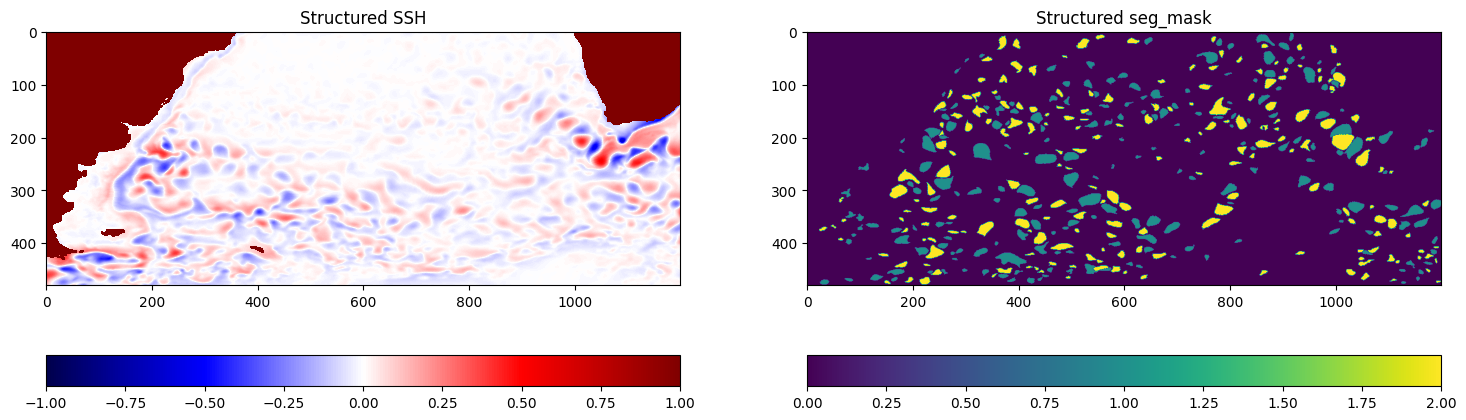

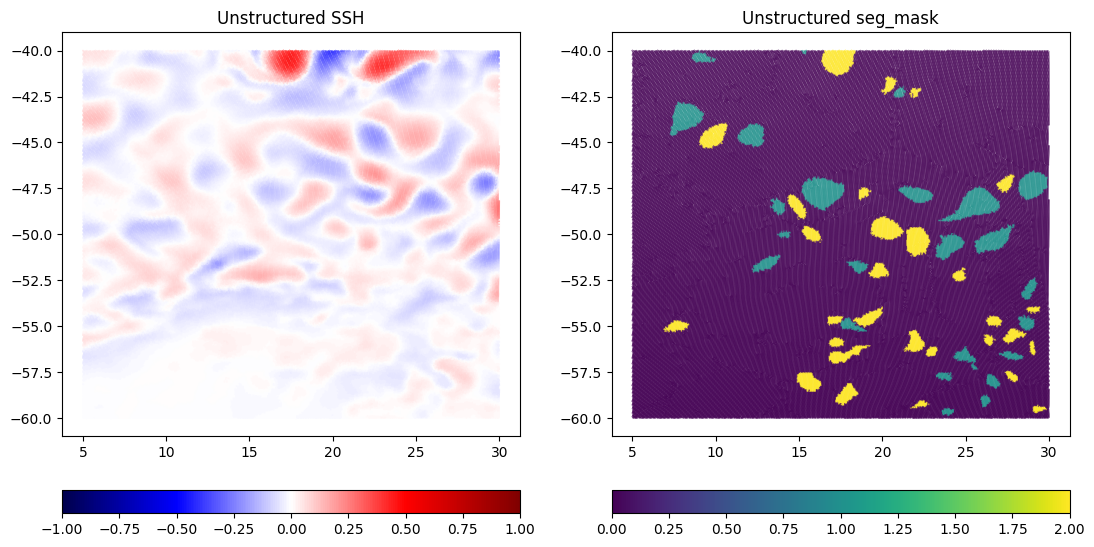

In [12]:
# Structured data
str_ssh = data_month.ssh.values[-1]
str_seg_mask = data_month.seg_mask.values[-1]

fig, axes = plt.subplots(1, 2, figsize=(18, 9))

im = axes[0].imshow(np.flipud(str_ssh.T), cmap=cm.seismic, vmin=-1, vmax=1)
axes[0].set_title("Structured SSH")
cb = plt.colorbar(im, orientation='horizontal', pad=0.1, ax=axes[0])

im2 = axes[1].imshow(np.flipud(str_seg_mask.T), cmap=cm.viridis, vmin=0, vmax=2)
axes[1].set_title("Structured seg_mask")
cb = plt.colorbar(im2, orientation='horizontal', pad=0.1, ax=axes[1])

# Unstructured data
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values
uns_ssh = data_output.ssh.values
uns_seg_mask = data_output.seg_mask.values

fig, axes = plt.subplots(1, 2, figsize=(13, 7))

im3 = axes[0].scatter(model_lon_roi, model_lat_roi, c=uns_ssh, s=0.1, cmap=cm.seismic, vmin=-1, vmax=1)
axes[0].set_title(f"Unstructured SSH")
plt.colorbar(im3, orientation='horizontal', pad=0.1, ax=axes[0])

im4 = axes[1].scatter(model_lon_roi, model_lat_roi, c=uns_seg_mask, s=0.1, cmap=cm.viridis, vmin=0, vmax=2)
axes[1].set_title(f"Unstructured seg_mask")
plt.colorbar(im4, orientation='horizontal', pad=0.1, ax=axes[1])